In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

from glob import glob
from PIL import Image, ImageDraw, ImageFont

In [2]:
path_Cityscapes = '/media/mvlab/46FA9CA2FA9C8FB3/dataset/cityscapes/'
os.path.isdir(path_Cityscapes)

True

In [5]:
path_Cityscapes_box = path_Cityscapes + 'gtBbox_cityPersons_trainval/gtBboxCityPersons/'
os.path.isdir(path_Cityscapes_box)

True

In [122]:
path_Cityscapes_images = path_Cityscapes + 'leftImg8bit/'
os.path.isdir(path_Cityscapes_box)

True

In [6]:
path_Cityscapes_box_train = path_Cityscapes_box + 'train/'

os.path.isdir(path_Cityscapes_box_train)

True

In [127]:
path_images = glob(path_Cityscapes_images + '*/*/*')
path_images = np.sort(path_images)
len(path_images), path_images[0]

(5000,
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/cityscapes/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png')

In [126]:
path_annotation_box = glob(path_Cityscapes_box_train + '*/*')
path_annotation_box = np.sort(path_annotation_box)
len(path_annotation_box), path_annotation_box[0]

(2975,
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/cityscapes/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/aachen/aachen_000000_000019_gtBboxCityPersons.json')

In [51]:
class_names = ['ignore', 'pedestrian', 'rider', 'sitting person','person (other)', 'person group']
len(class_names)

6

In [191]:
def parse_box_from_json(path_json, is_print=False):
    if is_print:
        print('path_json', path_json)
        
    with open(path_json) as json_file:
        
        json_data = json.load(json_file)
        
        file_name = path_json.split(os.sep)[-1]
        
        objects = json_data['objects']
        if is_print:
            print('objects', len(objects), type(objects))
        
        if len(objects) < 1:
            if is_print:
                print('no pedestrian', len(objects), file_name)            
            return 
        
        boxes = []
        for obj in objects:
            if is_print:
                print('obj', obj)
            bboxVis = obj['bboxVis']
            label = obj['label']
            #print('bboxVis', bboxVis)
            x, y, w, h = bboxVis        
            #print('x, y, w, h', x, y, w, h, label)
            cls = class_names.index(label)
            box = [x, y, x + w, y + h, cls]
            #box = [cls, x, y, w, h]
            boxes.append(box)
            
    return boxes

In [192]:
#test
path_sample = path_annotation_box[0]
boxes = parse_box_from_json(path_sample, is_print=False)
boxes

[[892, 445, 913, 498, 3],
 [901, 443, 935, 498, 3],
 [1844, 441, 1888, 542, 2],
 [1025, 215, 1053, 249, 0]]

In [193]:
def extract_image_identity_name(path_anno_box):
    file_name_json = path_anno_box.split(os.sep)[-1]
    file_name_json = file_name_json.split('.')[0]
    under_bar_rindex = file_name_json.rindex('_')
    file_name_img = file_name_json[:under_bar_rindex]
    return file_name_img

In [194]:
dict_image_full_path = dict()
for path_image in path_images:
    img_iden_name = extract_image_identity_name(path_image)
    #print('img_iden_name', img_iden_name)
    dict_image_full_path[img_iden_name] = path_image

len(dict_image_full_path)

5000

In [195]:
annotation_Cityscapes = dict()

for path_anno_box in path_annotation_box:
    #print(path_anno_box)
    boxes = parse_box_from_json(path_anno_box, is_print=False)
    if boxes != None:
        file_name_img = extract_image_identity_name(path_anno_box)        
        #print('file_name_json', file_name_img)
        
        full_path_img = dict_image_full_path[file_name_img]        
        annotation_Cityscapes[full_path_img] = boxes        
    #break

len(dict_img_boxes)

2778

In [196]:
len(annotation_Cityscapes.values()), type(annotation_Cityscapes.values())

(2778, dict_values)

In [197]:
cbboxes = np.concatenate(list(annotation_Cityscapes.values()), axis=0)
cbboxes.shape

(27770, 5)

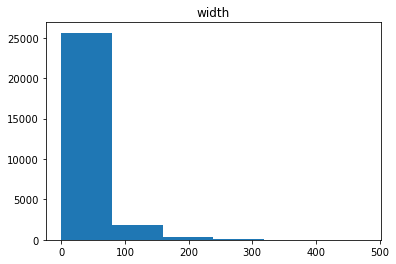

In [210]:
ax = plt.title('width')
ax = plt.hist(cbboxes[:, 2]-cbboxes[:, 0], bins=len(class_names))

class_names ['ignore', 'pedestrian', 'rider', 'sitting person', 'person (other)', 'person group']


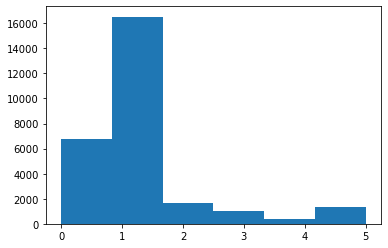

In [198]:
print('class_names', class_names)
ax = plt.hist(cbboxes[:, 4], bins=len(class_names))

In [222]:
max_data_m=100

In [223]:
def load_xy(annotation, rescale=1, stride=1, cut_top=False, size_cut=False):
    input_list = []
    bbox_list = []
    path_list = []
    for path_image in annotation:
        if stride!=1 and np.random.randint(1, 1+stride)%stride!=0:
            continue
            
        cls_bbox = annotation[path_image]                
        #print('cls_bbox', cls_bbox)
        cls_bbox = np.array(cls_bbox)
        bbox = np.array(cls_bbox[:, :4])
        attribute = cls_bbox[:, 4:]

        img = Image.open(path_image)
        scale = np.array((img.width, img.height, img.width, img.height))
        if rescale!=1:
            img = img.resize((img.width//rescale, img.height//rescale))

        img_arr = np.array(img)
        if img_arr.ndim < 3:
            print('warn dimension', img_arr.ndim, path_image)
            continue
       
        scale = np.reshape(scale, (1, 4))
        
        try:
            std_v = np.std(img_arr)
            if std_v < 3:
                print('std_v', std_v)
                continue
        except:
            print('error', path_image)
            continue

        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((bbox_norm, attribute), axis=1)

        if size_cut:                
            box_height = cls_bbox_norm[:, 3] - cls_bbox_norm[:, 1]
            box_height_max = np.max(box_height)
            if box_height_max < 0.05 or box_height_max > 0.2:
                continue

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        path_list.append(path_image)
        if len(input_list)%100==0:        
            print(len(annotation), len(input_list), len(bbox_list))   
        if len(input_list) > max_data_m:
            break       

    print(len(input_list), len(bbox_list))
    return input_list, bbox_list

In [224]:
input_list, bbox_list = load_xy(annotation_Cityscapes)
#error /home/mvlab/Downloads/dataset/통영/도천2/01748.png

2778 100 100
101 101


In [225]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [226]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1], display_1=False):
    
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        if display_1:
            if int(cls)!=1:
                continue
        #x1, y1, w, h, = box
        x1, y1, x2, y2, = box
        w, h = x2 - x1, y2 - y1
        color = [1,1,1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            score_txt = str(cls)
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 4]
            bbox = sample_box[:, 0:4]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

0 [0. 2. 3.]


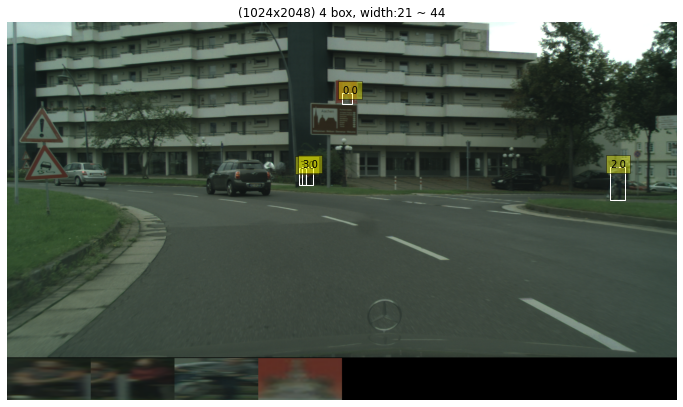

10 [0. 1. 2.]


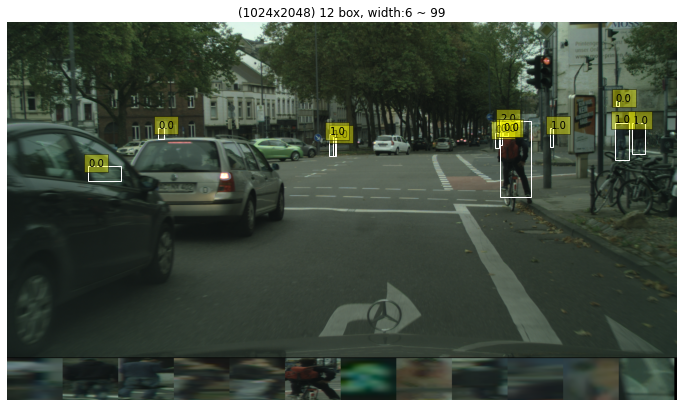

20 [1.]


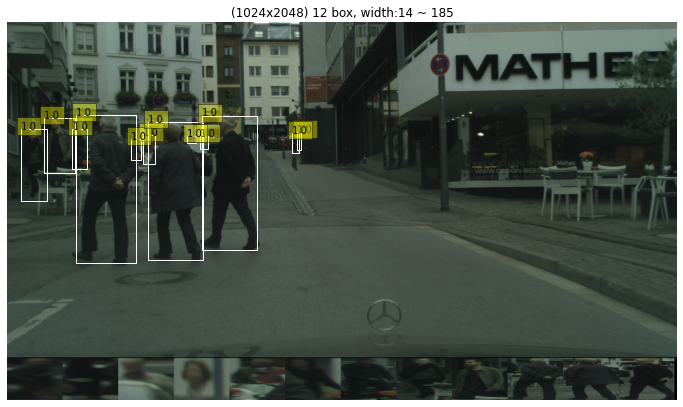

30 [0. 1.]


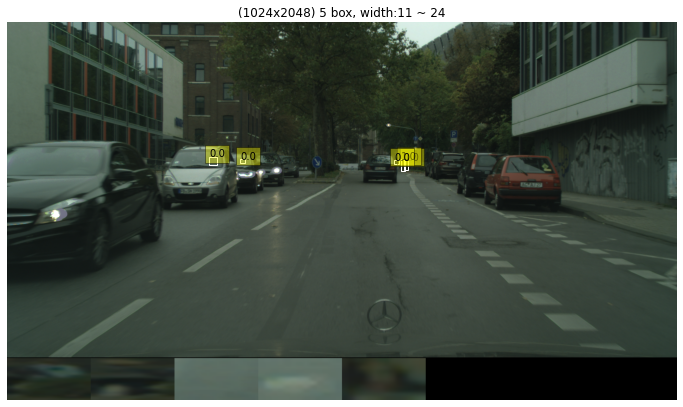

40 [0. 1. 3. 5.]
crop_bbox_image 0 0 crop_image_arr.shape (0, 0, 3)
crop_bbox_image 0 0 crop_image_arr.shape (0, 0, 3)


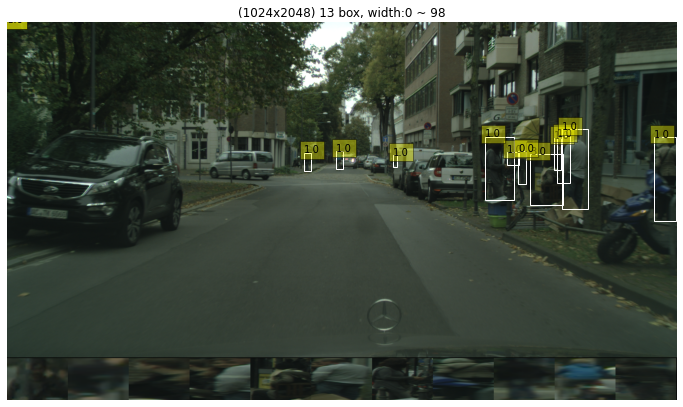

50 [0. 1. 2.]


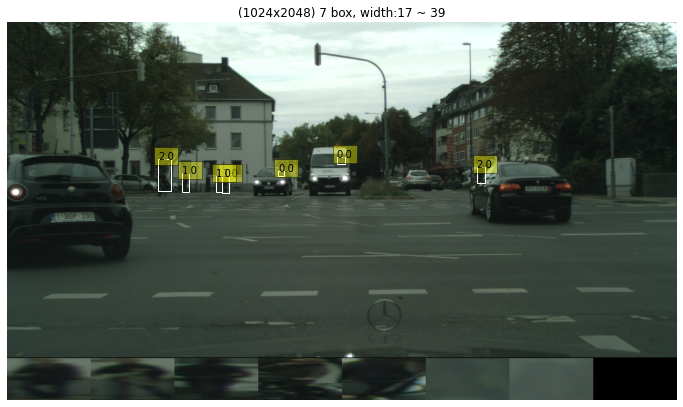

60 [1.]


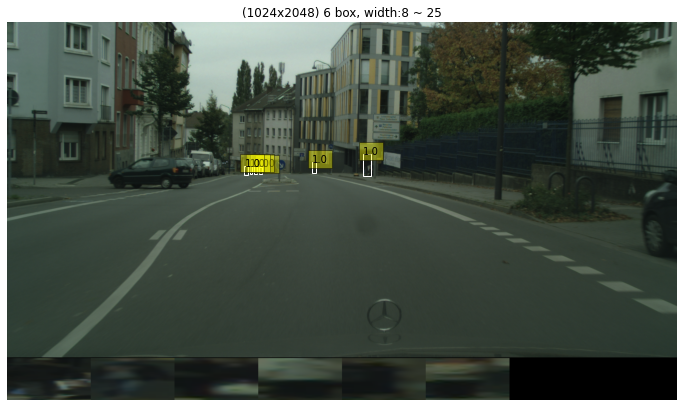

70 [0. 1.]


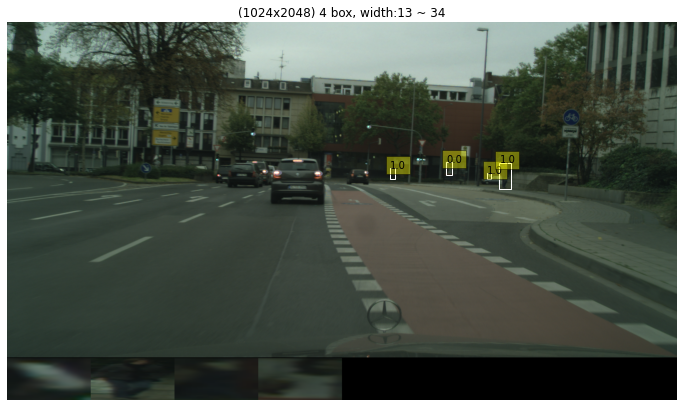

80 [0. 1.]


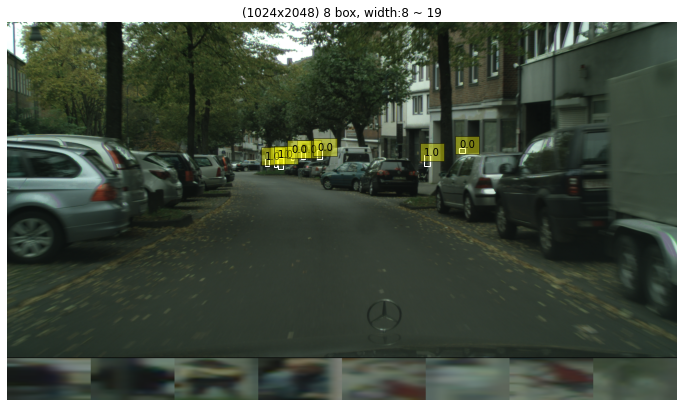

90 [0. 1.]


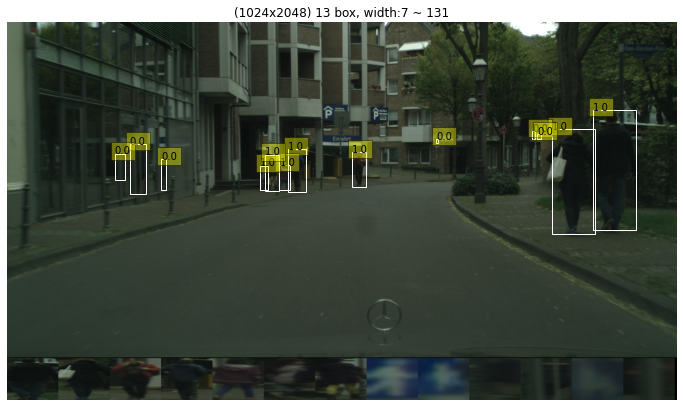

100 [0.]


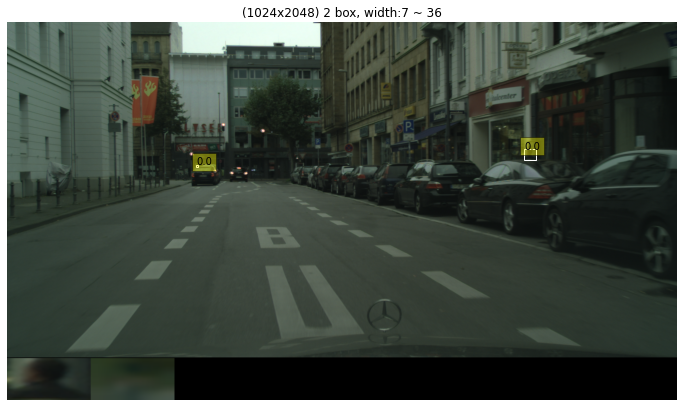

In [228]:
display_data(input_list, bbox_list, stride=10)